In [1]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  9% | 96% |
|  1 |  0% |  3% |
|  2 |  0% |  3% |
|  3 |  0% |  3% |
|  4 |  0% |  0% |
|  5 |  1% |  0% |
|  6 |  1% |  0% |
|  7 |  0% |  0% |


In [2]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [4]:
from arm_preprocessing import generate_word_list, vocab_generator, generate_typed_encodings
from model import ARM

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

Import Processed Typed Datasets

In [6]:
trrust = pd.read_csv('trrust_norm_rel.csv')
trrust = trrust[trrust.match == 1]
int_class_dict =  {'Activation': 'positive', 'Repression': 'negative', 'Unknown': 'undefined'}
trrust.interaction = trrust.interaction.apply(lambda x: int_class_dict[x])
trrust = trrust.drop(columns = 'match')
trrust = trrust.drop_duplicates(subset = ['source', 'target', 'sentence'])
print('No of sentences with entity mentions:', trrust.shape[0])
trrust.head(5)

No of sentences with entity mentions: 22276


,pmid,source,target,interaction,sentence
1,10022128,MYC,TERT,positive,Here we identify the myc transcription factor...
2,10022128,MYC,TERT,positive,Through the use of a hormone inducible form o...
3,10022128,MYC,TERT,positive,These findings demonstrate that the TERT gene...
4,10022128,MYC,TERT,positive,Since telomerase activation frequently correl...
5,10022128,MYC,TERT,positive,Employing the rat embryo fibroblast cooperati...


In [7]:
air = pd.read_csv('air_norm_rel.csv')
air = air[air.match == 1]
air = air.drop(columns = 'match')
air = air.drop_duplicates(subset = ['source', 'target', 'sentence'])
print('No of sentences with entity mentions:', air.shape[0])
air.head(5)

No of sentences with entity mentions: 30214


,pmid,source,target,interaction,sentence
5,10022118,CASP3,CDKN1A,negative,We report herein that cdkn1a was cleaved by c...
7,10022118,CASP3,CDKN1A,negative,Thus casp3ase3mediated cleavage and inactivat...
16,10022513,ERG,HMOX1,positive,The presence of regulatory sequences for tran...
25,10022513,ETS1,HMOX1,positive,The presence of regulatory sequences for tran...
34,10022513,FLI1,HMOX1,positive,The presence of regulatory sequences for tran...


In [8]:
elangovan = pd.read_csv('elangovan_norm_rel.csv')
elangovan = elangovan[elangovan.match == 1]
elangovan = elangovan.drop(columns = 'match')
elangovan = elangovan[elangovan.interaction == 'phosphorylation']
elangovan = elangovan.drop_duplicates(subset = ['source', 'target', 'sentence'])
print('No of sentences with entity mentions:', elangovan.shape[0])
elangovan.head(5)

No of sentences with entity mentions: 1082


,pmid,source,target,interaction,sentence
0,10373560,MYT1,CDK1,phosphorylation,The myt1 protein kinase functions to negativel...
1,10373560,MYT1,CDK1,phosphorylation,Throughout interphase human myt1 localizes to...
3,10373560,MYT1,CDK1,phosphorylation,The COOHterminal 63 amino acids of myt1 were ...
4,10373560,MYT1,CDK1,phosphorylation,myt1 mutants lacking this domain no longer bo...
6,10373560,MYT1,CDK1,phosphorylation,These results suggest that the docking of cdk...


Generate vocabulary and sequence of words

In [9]:
trrust = generate_word_list(trrust)
air = generate_word_list(air)
elangovan = generate_word_list(elangovan)

In [10]:
list_of_words = [item for sublist in list(trrust.list_of_words)+list(air.list_of_words)+list(elangovan.list_of_words) for item in sublist]
VOCAB = vocab_generator(list_of_words, lowered = True, VOCAB = {})

VOCAB size = 35007


Text(0.5, 1.0, 'Sentence Length Sensity for Elangovan Data')

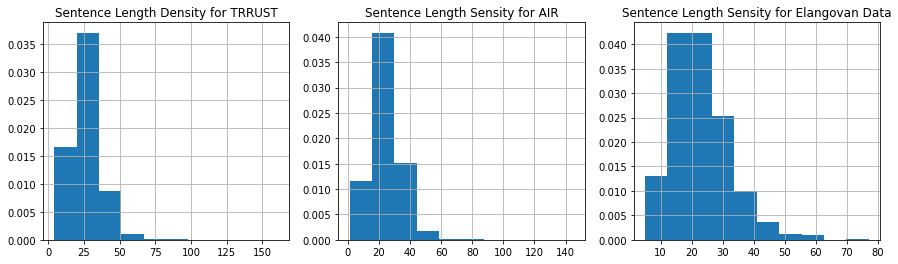

In [11]:
plt.figure(figsize = (15,4))
plt.subplot(131)
trrust.n_words.hist(density=True)
plt.title('Sentence Length Density for TRRUST')
plt.subplot(132)
air.n_words.hist(density=True)
plt.title('Sentence Length Sensity for AIR')
plt.subplot(133)
elangovan.n_words.hist(density=True)
plt.title('Sentence Length Sensity for Elangovan Data')


In [12]:
# Choose maximum length for modeling
maxl = int(max(trrust.n_words.quantile(q = 0.99), air.n_words.quantile(q = 0.99), elangovan.n_words.quantile(q = 0.99)) + 1)
print('Maximum sentence length:', maxl)

Maximum sentence length: 58


In [13]:
# Delete entries with sentence length more than maxl
print('No of entries in TRRUST:', trrust.shape[0])
trrust = trrust[trrust.n_words < maxl]
print('No of entries in TRRUST after dropping sentences having length more than maxl:', trrust.shape[0])

print('\n')

print('No of entries in AIR:', air.shape[0])
air = air[air.n_words < maxl]
print('No of entries in AIR after dropping sentences having length more than maxl:', air.shape[0])

print('\n')

print('No of entries in Elangovan:', elangovan.shape[0])
elangovan = elangovan[elangovan.n_words < maxl]
print('No of entries in Elangovan after dropping sentences having length more than maxl:', elangovan.shape[0])

No of entries in TRRUST: 22276
No of entries in TRRUST after dropping sentences having length more than maxl: 22062


No of entries in AIR: 30214
No of entries in AIR after dropping sentences having length more than maxl: 30053


No of entries in Elangovan: 1082
No of entries in Elangovan after dropping sentences having length more than maxl: 1079


Generate Typed Encodings and Tokens

In [14]:
# Interaction Class dict
interaction_dict = {'undefined':['bind', 'interact'],
                    'positive': ['activat', 'upregulat'],
                    'negative': ['repress', 'downregulat', 'inhibit'],
                    'phosphorylation': ['phosphorylat']}

In [15]:
trrust_int_df = generate_typed_encodings(trrust, maxl, VOCAB, interaction_dict)
air_int_df = generate_typed_encodings(air, maxl, VOCAB, interaction_dict)
elangovan_int_df = generate_typed_encodings(elangovan, maxl, VOCAB, interaction_dict)

In [16]:
# Delete entries with no interaction keys or entities
# Delete entries with more than four mentions
trrust_int_df = trrust_int_df[(trrust_int_df.n_int > 0) & (trrust_int_df.n_int < 5)] 
trrust_int_df = trrust_int_df[(trrust_int_df.n_source > 0) & (trrust_int_df.n_source < 5)] 
trrust_int_df = trrust_int_df[(trrust_int_df.n_target > 0) & (trrust_int_df.n_target < 5)] 

air_int_df = air_int_df[(air_int_df.n_int > 0) & (air_int_df.n_int < 5)] 
air_int_df = air_int_df[(air_int_df.n_source > 0) & (air_int_df.n_source < 5)] 
air_int_df = air_int_df[(air_int_df.n_target > 0) & (air_int_df.n_target < 5)]

elangovan_int_df = elangovan_int_df[(elangovan_int_df.n_int > 0) & (elangovan_int_df.n_int < 5)] 
elangovan_int_df = elangovan_int_df[(elangovan_int_df.n_source > 0) & (elangovan_int_df.n_source < 5)] 
elangovan_int_df = elangovan_int_df[(elangovan_int_df.n_target > 0) & (elangovan_int_df.n_target < 5)]

Plots for number of entity and interaction key mentions

Text(0.5, 1.0, 'No of target gene mention')

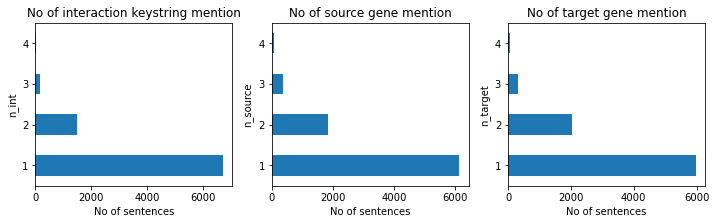

In [17]:
# TRRUST
plt.figure(figsize = (12,3))
plt.subplot(131)
trrust_int_df.groupby("n_int")['n_int'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of interaction keystring mention')

plt.subplot(132)
trrust_int_df.groupby("n_source")['n_source'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of source gene mention')

plt.subplot(133)
trrust_int_df.groupby("n_target")['n_target'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of target gene mention')

Text(0.5, 1.0, 'No of target gene mention')

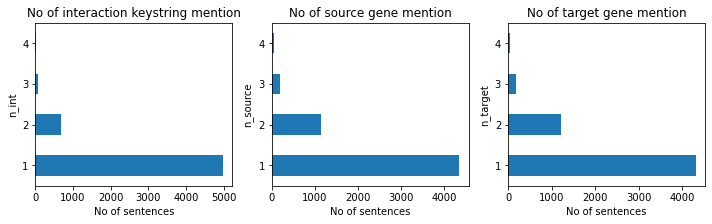

In [18]:
# AIR
plt.figure(figsize = (12,3))
plt.subplot(131)
air_int_df.groupby("n_int")['n_int'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of interaction keystring mention')

plt.subplot(132)
air_int_df.groupby("n_source")['n_source'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of source gene mention')

plt.subplot(133)
air_int_df.groupby("n_target")['n_target'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of target gene mention')

Text(0.5, 1.0, 'No of target gene mention')

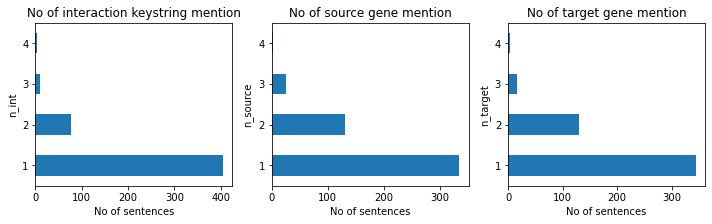

In [19]:
# Elangovan
plt.figure(figsize = (12,3))
plt.subplot(131)
elangovan_int_df.groupby("n_int")['n_int'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of interaction keystring mention')

plt.subplot(132)
elangovan_int_df.groupby("n_source")['n_source'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of source gene mention')

plt.subplot(133)
elangovan_int_df.groupby("n_target")['n_target'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of target gene mention')

1776 negative {'bind': [18], 'interact': [], 'activat': [], 'upregulat': [], 'repress': [], 'downregulat': [], 'inhibit': [6, 14], 'phosphorylat': []}  The ability of pparg ligands to inhibit ptgs2 appears to be mediated predominantly through inhibition of AP1 protein binding to the CRE site in the ptgs2 promoter


<AxesSubplot:xlabel='words', ylabel='relative_indexing_source'>

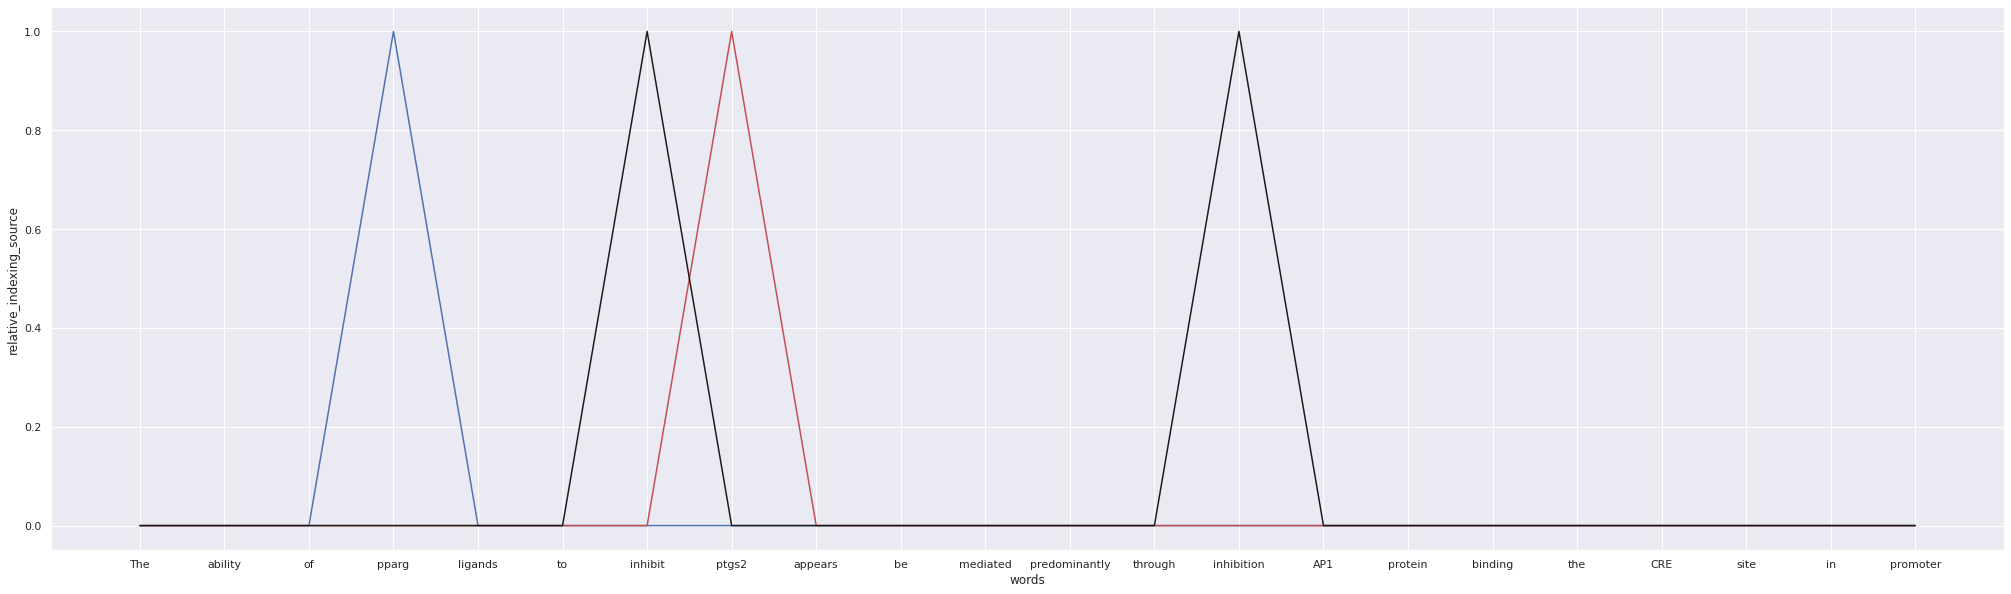

In [20]:
# Encoding Plots
n = np.random.randint(len(trrust_int_df))
print(n, trrust_int_df.iloc[n].interaction, trrust_int_df.iloc[n].int_words, trrust_int_df.iloc[n].sentence)
d = {'words':trrust_int_df.iloc[n].list_of_words,'relative_indexing_source': trrust_int_df.iloc[n].source_embd[:trrust_int_df.iloc[n].n_words], \
     'relative_indexing_interation': trrust_int_df.iloc[n].int_embd[:trrust_int_df.iloc[n].n_words], 'relative_indexing_target': trrust_int_df.iloc[n].target_embd[:trrust_int_df.iloc[n].n_words]}
df = pd.DataFrame(d)
sns.set(rc={'figure.figsize':(35,10)})
sns.lineplot(x='words', y='relative_indexing_source', data=df)
sns.lineplot(x='words', y='relative_indexing_target', data=df, color='r')
sns.lineplot(x='words', y='relative_indexing_interation', data=df, color='k')

2105 positive {'bind': [], 'interact': [], 'activat': [33], 'upregulat': [], 'repress': [], 'downregulat': [2], 'inhibit': [], 'phosphorylat': []}  Therefore the downregulation of the sh2d1a gene by ATF5 may represent a common mechanism for the pathogenesis of HPS that is associated with either EpsteinBarr virus infection or immune disorders with dysregulated Tcell activation


<AxesSubplot:xlabel='words', ylabel='relative_indexing_source'>

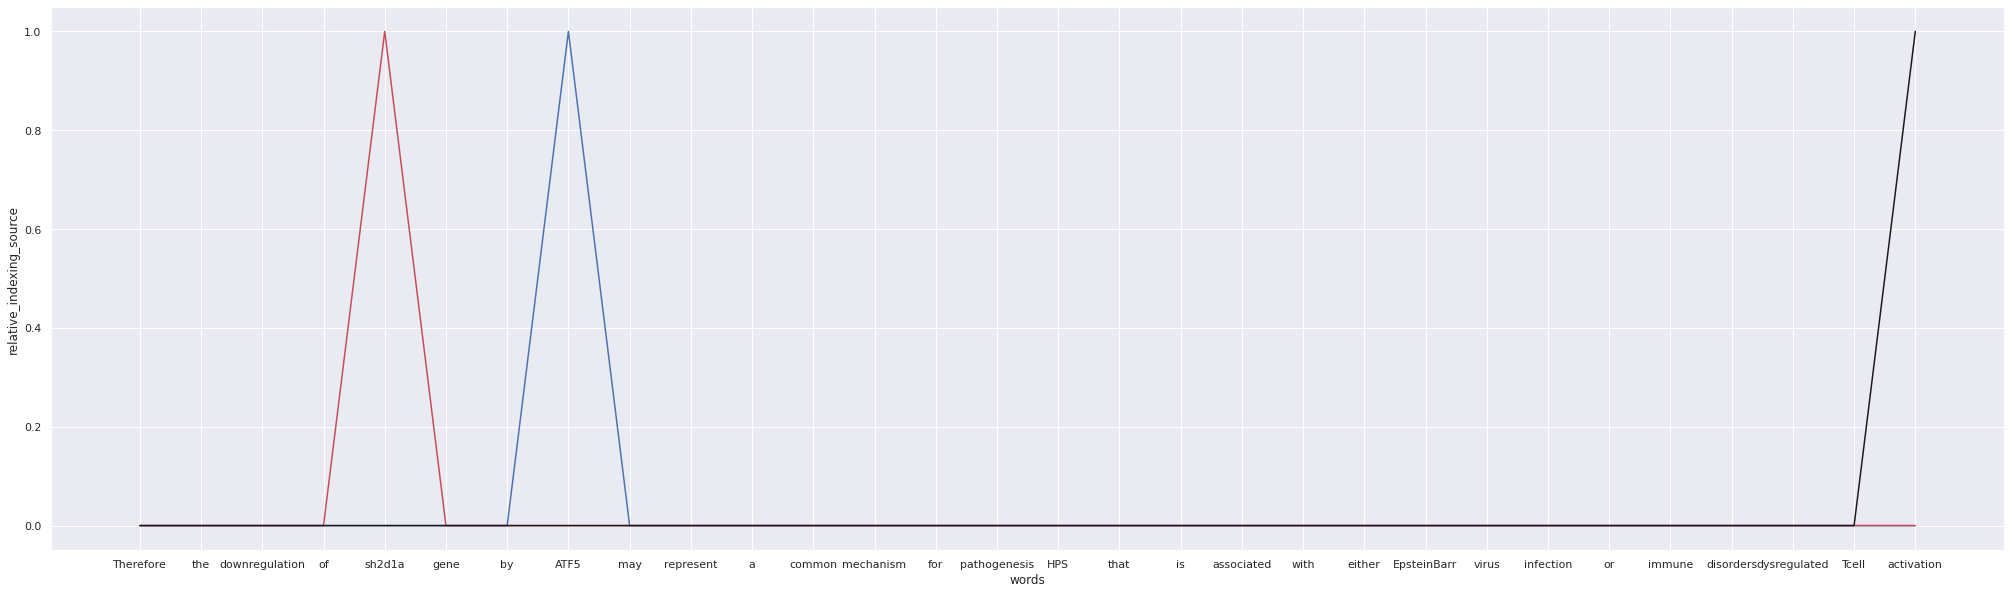

In [21]:
# Encoding Plots
n = np.random.randint(len(air_int_df))
print(n, air_int_df.iloc[n].interaction, air_int_df.iloc[n].int_words, air_int_df.iloc[n].sentence)
d = {'words':air_int_df.iloc[n].list_of_words,'relative_indexing_source': air_int_df.iloc[n].source_embd[:air_int_df.iloc[n].n_words], \
     'relative_indexing_interation': air_int_df.iloc[n].int_embd[:air_int_df.iloc[n].n_words], 'relative_indexing_target': air_int_df.iloc[n].target_embd[:air_int_df.iloc[n].n_words]}
df = pd.DataFrame(d)
sns.set(rc={'figure.figsize':(35,10)})
sns.lineplot(x='words', y='relative_indexing_source', data=df)
sns.lineplot(x='words', y='relative_indexing_target', data=df, color='r')
sns.lineplot(x='words', y='relative_indexing_interation', data=df, color='k')

446 phosphorylation {'bind': [], 'interact': [], 'activat': [], 'upregulat': [], 'repress': [], 'downregulat': [], 'inhibit': [], 'phosphorylat': [12]}  Here we show that Fam20A potentiates dmp4 kinase activity and promotes the phosphorylation of enamel matrix proteins in vitro and in cells


<AxesSubplot:xlabel='words', ylabel='relative_indexing_source'>

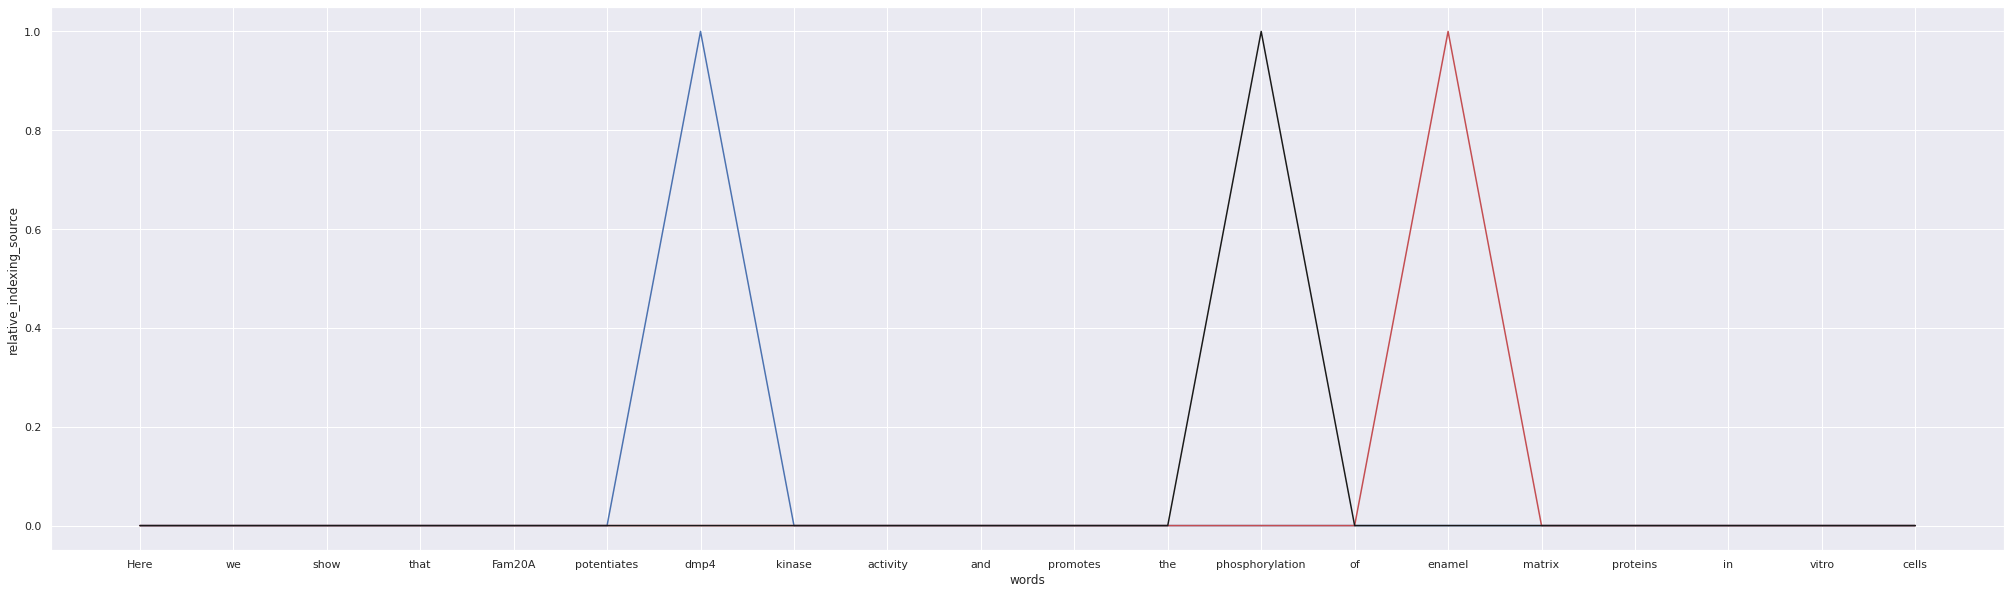

In [22]:
# Encoding Plots
n = np.random.randint(len(elangovan_int_df))
print(n, elangovan_int_df.iloc[n].interaction, elangovan_int_df.iloc[n].int_words, elangovan_int_df.iloc[n].sentence)
d = {'words':elangovan_int_df.iloc[n].list_of_words,'relative_indexing_source': elangovan_int_df.iloc[n].source_embd[:elangovan_int_df.iloc[n].n_words], \
     'relative_indexing_interation': elangovan_int_df.iloc[n].int_embd[:elangovan_int_df.iloc[n].n_words], 'relative_indexing_target': elangovan_int_df.iloc[n].target_embd[:elangovan_int_df.iloc[n].n_words]}
df = pd.DataFrame(d)
sns.set(rc={'figure.figsize':(35,10)})
sns.lineplot(x='words', y='relative_indexing_source', data=df)
sns.lineplot(x='words', y='relative_indexing_target', data=df, color='r')
sns.lineplot(x='words', y='relative_indexing_interation', data=df, color='k')

In [23]:
print('TRRUST')
print('No of sentences:', trrust_int_df.shape[0])
print('No of unique entities:', len(set(trrust_int_df.source.str.lower().to_list() + trrust_int_df.target.str.lower().to_list())))
print('-'*25)
print('AIR')
print('No of sentences:', air_int_df.shape[0])
print('No of unique entities:', len(set(air_int_df.source.str.lower().to_list() + air_int_df.target.str.lower().to_list())))
print('-'*25)
print('Elangovan')
print('No of sentences:', elangovan_int_df.shape[0])
print('No of unique entities:', len(set(elangovan_int_df.source.str.lower().to_list() + elangovan_int_df.target.str.lower().to_list())))

TRRUST
No of sentences: 8395
No of unique entities: 2044
-------------------------
AIR
No of sentences: 5758
No of unique entities: 2085
-------------------------
Elangovan
No of sentences: 494
No of unique entities: 258


In [24]:
# Train df
train_int_df = trrust_int_df.append(air_int_df).reset_index(drop = True)
# Val df
val_int_df = elangovan_int_df.reset_index(drop = True)

print('Curated Dataset: Training and Testing')
print('No of sentences:', train_int_df.shape[0])
print('No of unique entities:', len(set(train_int_df.source.str.lower().to_list() + train_int_df.target.str.lower().to_list())))
print('-'*25)
print('Curated Dataset: Validation')
print('No of sentences:', val_int_df.shape[0])
print('No of unique entities:', len(set(val_int_df.source.str.lower().to_list() + val_int_df.target.str.lower().to_list())))

Curated Dataset: Training and Testing
No of sentences: 14153
No of unique entities: 2913
-------------------------
Curated Dataset: Validation
No of sentences: 494
No of unique entities: 258


In [25]:
# 10-Fold
indx = np.arange(len(train_int_df))
fold_test_indxs = []

np.random.seed(10)
for i in range(10):
    f = np.random.choice(indx, int(len(train_int_df)/10), replace=False)
    fold_test_indxs.append(f)
    indx = indx[~np.in1d(indx, f)]

In [26]:
# Model Parameters
snip_len = maxl
embed_dim = 32
num_heads = 8
ff_dim = 32
vocab_size = len(VOCAB) + 1
dropout = 0.1
batch_size = 32

<b> INT > SRC </b>

In [27]:
test_eema_1 = []
test_eema_2 = []
test_eema_3 = []
val_eema_1 = []
val_eema_2 = []
val_eema_3 = []

In [28]:
for i in range(10):
    print(f'Fold {i+1}')
    test_indexes = fold_test_indxs[i]
    train_indexes = np.array([x for x in list(range(len(train_int_df))) if x not in test_indexes])
    train_df = train_int_df.iloc[train_indexes].reset_index(drop = True)
    test_df = train_int_df.iloc[test_indexes].reset_index(drop = True)
    print('Train size:', train_df.shape, 'Test size:', test_df.shape)
    
    X_train=tf.convert_to_tensor(np.array([train_df.tokens.tolist(),train_df.int_embd.tolist()]))
    X_test=tf.convert_to_tensor(np.array([test_df.tokens.tolist(),test_df.int_embd.tolist()]))
    y_train=tf.convert_to_tensor(train_df.source_embd.tolist())
    y_test=tf.convert_to_tensor(test_df.source_embd.tolist())
    print('X train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape, 'y_test', y_test.shape)
    
    X_ext=tf.convert_to_tensor(np.array([val_int_df.tokens.tolist(),val_int_df.int_embd.tolist()]))
    y_ext=tf.convert_to_tensor(val_int_df.source_embd.tolist())
    print('X ext', X_ext.shape, 'y ext', y_ext.shape)
    
    model = ARM(snip_len, embed_dim, num_heads, ff_dim, dropout, vocab_size)
    model.compile('adam', loss = 'mse')
    
    history = model.fit([X_train[0],X_train[1]], y_train, batch_size=batch_size, epochs=100, 
                           validation_split=.2, shuffle=True, verbose = 0)
    
    # TEST
    print('Test')
    # 1-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('1-EEMA score:', np.mean(pred_label))
    test_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    test_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label))
    test_eema_3.append(np.mean(pred_label))
    
    # Validation
    print('Validation')
    # 1-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        if y_hat in gene_pos:
            pred_label.append(1)
        else:
            pred_label.append(0)   
    print('1-EEMA score:', np.mean(pred_label))
    val_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    val_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label), '\n')
    val_eema_3.append(np.mean(pred_label))

Fold 1
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.792226148409894
2-EEMA score: 0.9137809187279152
3-EEMA score: 0.9568904593639576
Validation
1-EEMA score: 0.2692307692307692
2-EEMA score: 0.46356275303643724
3-EEMA score: 0.6093117408906883 

Fold 2
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.7780918727915195
2-EEMA score: 0.9031802120141342
3-EEMA score: 0.9491166077738515
Validation
1-EEMA score: 0.3117408906882591
2-EEMA score: 0.4959514170040486
3-EEMA score: 0.631578947368421 

Fold 3
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.7752650176678445
2-EEMA score: 0.91378

In [29]:
print('TEST')
print('1-EEMA score:', np.mean(test_eema_1))
print('2-EEMA score:', np.mean(test_eema_2))
print('3-EEMA score:', np.mean(test_eema_3))

TEST
1-EEMA score: 0.7695406360424029
2-EEMA score: 0.9036749116607774
3-EEMA score: 0.952226148409894


In [30]:
print('VAL')
print('1-EEMA score:', np.mean(val_eema_1))
print('2-EEMA score:', np.mean(val_eema_2))
print('3-EEMA score:', np.mean(val_eema_3))

VAL
1-EEMA score: 0.30242914979757085
2-EEMA score: 0.4937246963562753
3-EEMA score: 0.6246963562753036


<b> INT > TRGT </b>

In [31]:
test_eema_1 = []
test_eema_2 = []
test_eema_3 = []
val_eema_1 = []
val_eema_2 = []
val_eema_3 = []

In [32]:
for i in range(10):
    print(f'Fold {i+1}')
    test_indexes = fold_test_indxs[i]
    train_indexes = np.array([x for x in list(range(len(train_int_df))) if x not in test_indexes])
    train_df = train_int_df.iloc[train_indexes].reset_index(drop = True)
    test_df = train_int_df.iloc[test_indexes].reset_index(drop = True)
    print('Train size:', train_df.shape, 'Test size:', test_df.shape)
    
    X_train=tf.convert_to_tensor(np.array([train_df.tokens.tolist(),train_df.int_embd.tolist()]))
    X_test=tf.convert_to_tensor(np.array([test_df.tokens.tolist(),test_df.int_embd.tolist()]))
    y_train=tf.convert_to_tensor(train_df.target_embd.tolist())
    y_test=tf.convert_to_tensor(test_df.target_embd.tolist())
    print('X train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape, 'y_test', y_test.shape)
    
    X_ext=tf.convert_to_tensor(np.array([val_int_df.tokens.tolist(),val_int_df.int_embd.tolist()]))
    y_ext=tf.convert_to_tensor(val_int_df.target_embd.tolist())
    print('X ext', X_ext.shape, 'y ext', y_ext.shape)
    
    model = ARM(snip_len, embed_dim, num_heads, ff_dim, dropout, vocab_size)
    model.compile('adam', loss = 'mse')
    
    history = model.fit([X_train[0],X_train[1]], y_train, batch_size=batch_size, epochs=100, 
                           validation_split=.2, shuffle=True, verbose = 0)
    
    # TEST
    print('Test')
    # 1-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('1-EEMA score:', np.mean(pred_label))
    test_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    test_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label))
    test_eema_3.append(np.mean(pred_label))
    
    # Validation
    print('Validation')
    # 1-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        if y_hat in gene_pos:
            pred_label.append(1)
        else:
            pred_label.append(0)   
    print('1-EEMA score:', np.mean(pred_label))
    val_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    val_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label), '\n')
    val_eema_3.append(np.mean(pred_label))

Fold 1
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.7865724381625442
2-EEMA score: 0.8833922261484098
3-EEMA score: 0.927208480565371
Validation
1-EEMA score: 0.3117408906882591
2-EEMA score: 0.47368421052631576
3-EEMA score: 0.5951417004048583 

Fold 2
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.7985865724381626
2-EEMA score: 0.8925795053003533
3-EEMA score: 0.927208480565371
Validation
1-EEMA score: 0.305668016194332
2-EEMA score: 0.4574898785425101
3-EEMA score: 0.5910931174089069 

Fold 3
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.7985865724381626
2-EEMA score: 0.881272

In [33]:
print('TEST')
print('1-EEMA score:', np.mean(test_eema_1))
print('2-EEMA score:', np.mean(test_eema_2))
print('3-EEMA score:', np.mean(test_eema_3))

TEST
1-EEMA score: 0.7929328621908127
2-EEMA score: 0.8869257950530034
3-EEMA score: 0.9265017667844522


In [34]:
print('VAL')
print('1-EEMA score:', np.mean(val_eema_1))
print('2-EEMA score:', np.mean(val_eema_2))
print('3-EEMA score:', np.mean(val_eema_3))

VAL
1-EEMA score: 0.30344129554655874
2-EEMA score: 0.4732793522267206
3-EEMA score: 0.5997975708502024


<b> SRC > TRGT </b>

In [35]:
test_eema_1 = []
test_eema_2 = []
test_eema_3 = []
val_eema_1 = []
val_eema_2 = []
val_eema_3 = []

In [36]:
for i in range(10):
    print(f'Fold {i+1}')
    test_indexes = fold_test_indxs[i]
    train_indexes = np.array([x for x in list(range(len(train_int_df))) if x not in test_indexes])
    train_df = train_int_df.iloc[train_indexes].reset_index(drop = True)
    test_df = train_int_df.iloc[test_indexes].reset_index(drop = True)
    print('Train size:', train_df.shape, 'Test size:', test_df.shape)
    
    X_train=tf.convert_to_tensor(np.array([train_df.tokens.tolist(),train_df.source_embd.tolist()]))
    X_test=tf.convert_to_tensor(np.array([test_df.tokens.tolist(),test_df.source_embd.tolist()]))
    y_train=tf.convert_to_tensor(train_df.target_embd.tolist())
    y_test=tf.convert_to_tensor(test_df.target_embd.tolist())
    print('X train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape, 'y_test', y_test.shape)
    
    X_ext=tf.convert_to_tensor(np.array([val_int_df.tokens.tolist(),val_int_df.source_embd.tolist()]))
    y_ext=tf.convert_to_tensor(val_int_df.target_embd.tolist())
    print('X ext', X_ext.shape, 'y ext', y_ext.shape)
    
    model = ARM(snip_len, embed_dim, num_heads, ff_dim, dropout, vocab_size)
    model.compile('adam', loss = 'mse')
    
    history = model.fit([X_train[0],X_train[1]], y_train, batch_size=batch_size, epochs=100, 
                           validation_split=.2, shuffle=True, verbose = 0)
    
    # TEST
    print('Test')
    # 1-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('1-EEMA score:', np.mean(pred_label))
    test_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    test_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label))
    test_eema_3.append(np.mean(pred_label))
    
    # Validation
    print('Validation')
    # 1-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        if y_hat in gene_pos:
            pred_label.append(1)
        else:
            pred_label.append(0)   
    print('1-EEMA score:', np.mean(pred_label))
    val_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    val_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label), '\n')
    val_eema_3.append(np.mean(pred_label))

Fold 1
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.8487632508833922
2-EEMA score: 0.9293286219081273
3-EEMA score: 0.9519434628975265
Validation
1-EEMA score: 0.3967611336032389
2-EEMA score: 0.5748987854251012
3-EEMA score: 0.6781376518218624 

Fold 2
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.8473498233215547
2-EEMA score: 0.9137809187279152
3-EEMA score: 0.9399293286219081
Validation
1-EEMA score: 0.4392712550607287
2-EEMA score: 0.5951417004048583
3-EEMA score: 0.7024291497975709 

Fold 3
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.8522968197879859
2-EEMA score: 0.9257

In [37]:
print('TEST')
print('1-EEMA score:', np.mean(test_eema_1))
print('2-EEMA score:', np.mean(test_eema_2))
print('3-EEMA score:', np.mean(test_eema_3))

TEST
1-EEMA score: 0.8518727915194347
2-EEMA score: 0.9229681978798588
3-EEMA score: 0.9497526501766785


In [38]:
print('VAL')
print('1-EEMA score:', np.mean(val_eema_1))
print('2-EEMA score:', np.mean(val_eema_2))
print('3-EEMA score:', np.mean(val_eema_3))

VAL
1-EEMA score: 0.40728744939271255
2-EEMA score: 0.5908906882591094
3-EEMA score: 0.7038461538461538


<b> TRGT > SRC </b>

In [39]:
test_eema_1 = []
test_eema_2 = []
test_eema_3 = []
val_eema_1 = []
val_eema_2 = []
val_eema_3 = []

In [40]:
for i in range(10):
    print(f'Fold {i+1}')
    test_indexes = fold_test_indxs[i]
    train_indexes = np.array([x for x in list(range(len(train_int_df))) if x not in test_indexes])
    train_df = train_int_df.iloc[train_indexes].reset_index(drop = True)
    test_df = train_int_df.iloc[test_indexes].reset_index(drop = True)
    print('Train size:', train_df.shape, 'Test size:', test_df.shape)
    
    X_train=tf.convert_to_tensor(np.array([train_df.tokens.tolist(),train_df.target_embd.tolist()]))
    X_test=tf.convert_to_tensor(np.array([test_df.tokens.tolist(),test_df.target_embd.tolist()]))
    y_train=tf.convert_to_tensor(train_df.source_embd.tolist())
    y_test=tf.convert_to_tensor(test_df.source_embd.tolist())
    print('X train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape, 'y_test', y_test.shape)
    
    X_ext=tf.convert_to_tensor(np.array([val_int_df.tokens.tolist(),val_int_df.target_embd.tolist()]))
    y_ext=tf.convert_to_tensor(val_int_df.source_embd.tolist())
    print('X ext', X_ext.shape, 'y ext', y_ext.shape)
    
    model = ARM(snip_len, embed_dim, num_heads, ff_dim, dropout, vocab_size)
    model.compile('adam', loss = 'mse')
    
    history = model.fit([X_train[0],X_train[1]], y_train, batch_size=batch_size, epochs=100, 
                           validation_split=.2, shuffle=True, verbose = 0)
    
    # TEST
    print('Test')
    # 1-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('1-EEMA score:', np.mean(pred_label))
    test_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    test_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label))
    test_eema_3.append(np.mean(pred_label))
    
    # Validation
    print('Validation')
    # 1-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        if y_hat in gene_pos:
            pred_label.append(1)
        else:
            pred_label.append(0)   
    print('1-EEMA score:', np.mean(pred_label))
    val_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    val_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_ext[0],X_ext[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_ext[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label), '\n')
    val_eema_3.append(np.mean(pred_label))

Fold 1
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.8494699646643109
2-EEMA score: 0.937809187279152
3-EEMA score: 0.9674911660777386
Validation
1-EEMA score: 0.39271255060728744
2-EEMA score: 0.5708502024291497
3-EEMA score: 0.6963562753036437 

Fold 2
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.8424028268551237
2-EEMA score: 0.927208480565371
3-EEMA score: 0.9575971731448764
Validation
1-EEMA score: 0.4149797570850202
2-EEMA score: 0.5991902834008097
3-EEMA score: 0.7004048582995951 

Fold 3
Train size: (12738, 17) Test size: (1415, 17)
X train (2, 12738, 58) y_train (12738, 58) X_test (2, 1415, 58) y_test (1415, 58)
X ext (2, 494, 58) y ext (494, 58)
Test
1-EEMA score: 0.8459363957597174
2-EEMA score: 0.93710

In [41]:
print('TEST')
print('1-EEMA score:', np.mean(test_eema_1))
print('2-EEMA score:', np.mean(test_eema_2))
print('3-EEMA score:', np.mean(test_eema_3))

TEST
1-EEMA score: 0.8346289752650176
2-EEMA score: 0.932296819787986
3-EEMA score: 0.9645936395759718


In [42]:
print('VAL')
print('1-EEMA score:', np.mean(val_eema_1))
print('2-EEMA score:', np.mean(val_eema_2))
print('3-EEMA score:', np.mean(val_eema_3))

VAL
1-EEMA score: 0.39696356275303646
2-EEMA score: 0.5961538461538463
3-EEMA score: 0.7093117408906882
